# Optical flow Gaussian image denoising

In [1]:
#use_OpenCV = False
use_OpenCV = True
local_debug = True

In [2]:
import logging
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
#from ipywidgets import *
import cv2
import time
#import kernels
from skimage import io as skimage_io

In [3]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)

In [4]:
if local_debug:
    !ln -sf ../../information_theory/src/information_theory/ .
else:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
import information_theory  # pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"

In [5]:
if local_debug:
    !ln -sf ../../motion_estimation/src/motion_estimation/ .
else:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
if use_OpenCV:
    from motion_estimation._2D.farneback_OpenCV import Estimator_in_CPU as Estimator
    from motion_estimation._2D.project import project
else:
    from motion_estimation._1D.farneback_python import Estimator
    from motion_estimation._1D.project import project

In [6]:
GT = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/barb.png")

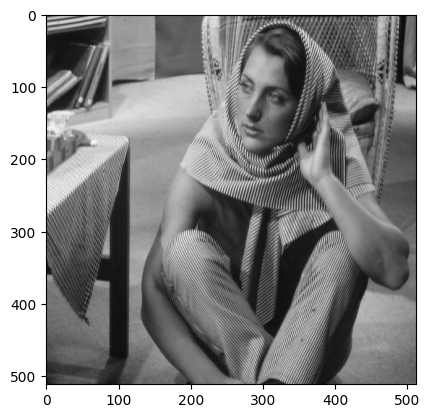

In [7]:
plt.imshow(GT, cmap="gray")

In [8]:
padded_GT = np.zeros(shape=(GT.shape[0]+32, GT.shape[1]+32), dtype=np.uint8)
padded_GT[16:-16, 16:-16] = GT
GT = padded_GT

In [9]:
mean = 0
var = 1000
sigma = 20 #var**0.5
noise = np.random.normal(mean, sigma, GT.shape).reshape(GT.shape)
noisy = np.clip(a=GT.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

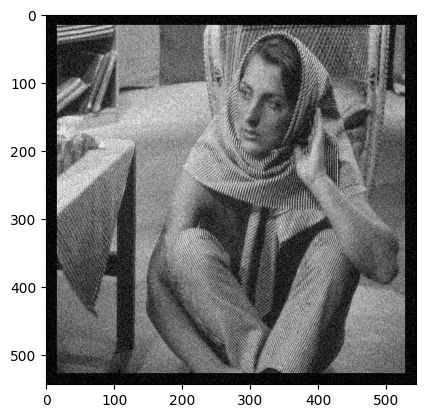

In [10]:
plt.imshow(noisy, cmap="gray")

0.9999999999999999


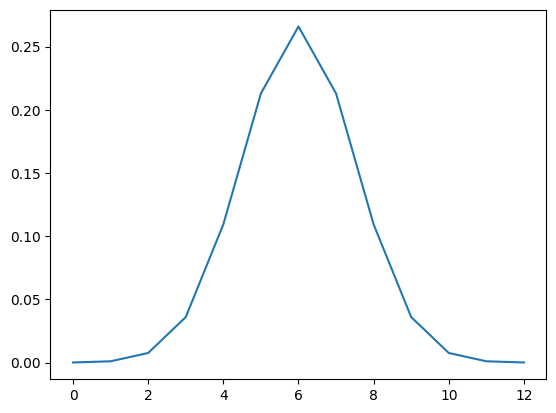

In [12]:
def get_gaussian_kernel(sigma=1):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

sigma = np.array([1.5, 1.5])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [11]:
import denoising.image.OF_gaussian as denoising

In [13]:
logger.setLevel(logging.INFO)
if use_OpenCV:
    denoiser = gaussian_denoising.Monochrome_Image_OF_Gaussian_Denoising(
        sigma_gaussian=sigma_gaussian,
        pyramid_levels=3,
        window_side=5,
        sigma_OF=1.0)
else:
    denoiser = denoising.Monochrome_Denoising(logger, N_poly=5, window_length=11)

NameError: name 'gaussian_denoising' is not defined

In [ ]:
denoised_img = denoiser.filter(noisy.astype(np.float64), kernel)

In [ ]:
denoised = np.clip(denoised_img, a_min=0, a_max=255)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(GT, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy, cmap="gray")
axs[1].set_title(f"Noisy ({information_theory.distortion.PSNR(noisy, GT):4.2f} dB)")
axs[2].imshow(denoised, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.PSNR(denoised, GT):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
input()

In [ ]:
if use_OpenCV:
    def filter(img, Estimator, l=3, w=5):
        w2 = (w + 1) // 2
        estimator = Estimator(win_side=w, pyr_levels=l, verbosity=logging.WARNING, poly_sigma=0.5)
        A = np.zeros_like(img, dtype=np.int16)
        for i in range(img.shape[0] - w):
            print(i, end=' ')
            R = img[i:i + w]
            T = img[i + 1: i + 1 + w].astype(np.float32)
            initial_flow = np.zeros(shape=(R.shape[0], R.shape[1], 2), dtype=np.float32)
            flow = estimator.pyramid_get_flow(target=T, reference=R, flow=initial_flow)
            compensated_slice = project(R, flow)
            compensated_line = compensated_slice[(w + 1) >> 1, :]
            A[i + w2] = (T[(w + 1) >> 1, :] + compensated_line) / 2
        return A
else:
    from numpy.linalg import LinAlgError
    def filter(img, Estimator, l=3, sigma_poly=4.0, sigma_flow=4.0):
        estimator = Estimator(logger, pyr_levels=l, sigma_poly=sigma_poly, sigma_flow=sigma_flow, num_iters=3)
        A = np.zeros_like(img, dtype=np.int16)
        for i in range(img.shape[0]-1):
            print(i, end=' ')
            R = img[i]
            T = img[i + 1].astype(np.float32)
            initial_flow = np.zeros_like(R, dtype=np.float32)
            try:
                initial_flow = np.zeros_like(R, dtype=np.float32)
                flow = estimator.pyramid_get_flow(target=T, reference=R, flow=initial_flow)
            except LinAlgError as e:
                print(f"Caught LinAlgError: {e}")
                flow = np.zeros_like(R)
            projected_line = project(logger, R, flow)
            print("avg flow=", np.average(np.abs(flow)))
            print(np.max(projected_line))
            A[i] = (T + projected_line) / 2
        return A

In [ ]:
denoised = noisy.copy()

In [ ]:
if use_OpenCV:
    denoised = filter(denoised, Estimator, w=5, l=3)
else:
    denoised = filter(denoised, Estimator, l=3, sigma_poly=4.0, sigma_flow=4.0)
denoised = np.transpose(denoised, (1, 0))
if use_OpenCV:
    denoised = filter(denoised, Estimator, w=2, l=3)
else:
    denoised = filter(denoised, Estimator, l=3, sigma_poly=4.0, sigma_flow=4.0)
denoised = np.transpose(denoised, (1, 0))
plt.imshow(denoised.astype(np.float32), cmap="gray")

In [ ]:
plt.imshow(denoised[40:480,40:480], cmap="gray")

In [ ]:
plt.imshow(d, cmap="gray")

In [ ]:
np.min(denoised)

In [ ]:
plt.imshow(noisy, cmap="gray")

In [ ]:
input()

In [ ]:
#import denoising.image.OF_gaussian as denoising
!pip install "image_denoising @ git+https://github.com/microscopy-processing/image_denoising"
!pip show image_denoising
import image_denoising
import logging
from image_denoising import OF_gaussian
image_denoising.OF_gaussian.logger.setLevel(logging.WARNING)
logging.getLevelName(image_denoising.OF_gaussian.logger.getEffectiveLevel())

In [ ]:
%%time

OFGD__sigma_kernel = 2.5
OFGD__N_iters = 1
OFGD__l = 4
OFGD__w = 25
OFGD__sigma_OF = 2.0

denoised_img, _ = image_denoising.OF_gaussian.filter_gray_image(noisy_img, OFGD__sigma_kernel, OFGD__N_iters, OFGD__l, OFGD__w, OFGD__sigma_OF)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy_img, cmap="gray")
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.avg_PSNR(denoised_img, img):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
import denoising.image.OF_gaussian as denoising

In [ ]:
import logging

In [ ]:
sigma = 2.0

In [ ]:
denoiser = denoising.Monochrome_Denoising(verbosity=logging.DEBUG, sigma_poly=4.0, sigma_flow=4.0, pyr_levels=2)
#denoiser = gaussian_denoising.Monochrome_Image_OF_Gaussian_Denoising(sigma_gaussian=sigma_gaussian, l=3, w=5, sigma_OF=1.0, verbosity=logging.DEBUG)

In [ ]:
kernel = denoiser.get_kernel(sigma)
print(kernel)
print(np.sum(kernel))
plt.plot(kernel)
plt.show()

In [ ]:
denoised_img, _ = denoiser.filter_iterate(noisy_img=img, GT=img, sigma=sigma)

In [ ]:
denoised_img = np.clip(denoised_img, a_min=0, a_max=255)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(noisy_img, cmap="gray")
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img, cmap="gray")
axs[2].set_title(f"Denoised ({information_theory.distortion.avg_PSNR(denoised_img, img):4.2f} dB)")
fig.tight_layout()
plt.show()

In [ ]:
img = skimage_io.imread("http://www.hpca.ual.es/~vruiz/images/lena.png")

In [ ]:
plt.imshow(img)

In [ ]:
mean = 0
var = 1000
sigma = var**0.5
noise = np.random.normal(mean,sigma,img.shape).reshape(img.shape)
noisy_img = np.clip(a=img.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

In [ ]:
plt.imshow(noisy_img)

In [ ]:
sigma_gaussian = 2.0

In [ ]:
denoiser = gaussian_denoising.Color_Image_OF_Gaussian_Denoising(
    sigma_gaussian=sigma_gaussian, l=3, w=5, sigma_OF=1.0, verbosity=logging.DEBUG)

In [ ]:
denoised_img, _ = denoiser.filter(noisy_image=noisy_img, GT=img)
denoised_img = denoised_img.astype(np.uint8)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(img)
axs[0].set_title("Original")
axs[1].imshow(noisy_img)
axs[1].set_title("Noisy")
axs[2].imshow(denoised_img)
axs[2].set_title("Denoised")
fig.tight_layout()
plt.show()